# PMiC Microscale Stable TEMPLATE
Makes first round of figures and save process data files for an individual WRF run

### File directories
Update for your system

In [1]:
### Simulation output directory
case_dir = '/p/lscratchh/mirocha2/SWiFT/2022/STABLE/STABLE_PERT_CASE_MESO_MICRO_NESTED_PERTS_ALL_BDYS_NGCV_1/'

### Process data output directory
pdata_dir = '/p/lustre3/lassman1/A2E_MMC/SWiFT/process_data/PMiC/STABLE/STABLE_PERT_CASE_MESO_MICRO_NESTED_PERTS_ALL_BDYS_NGCV_1_TEST/'

slice_2D_fn = 'horizontal_slices_d02_*'
slice_3D_fn = 'wrfout_d02_*'



### Import Modules

In [2]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
#import wrf # as wrf

import sys
import os
import glob

In [3]:
### MMCTOOLS path (update for your system)
# if you installed with conda, this is unnecessary
mmc_tools_path = os.path.join(os.environ['HOME'],'mmc/mmc_github_clones/mmctools/')
                                                       
if mmc_tools_path not in sys.path:
    sys.path.append(mmc_tools_path)
import mmctools
from mmctools.helper_functions import covariance, calc_wind 

In [4]:
# A few homemade functions (some stolen from @rthedin FINO code development)
from helper_functions_PMIC import *

In [5]:
if os.path.exists( pdata_dir):
    print("pdata directory exists")
else:
    print("making directory " + pdata_dir)
    os.mkdir( pdata_dir )

making directory /p/lustre3/lassman1/A2E_MMC/SWiFT/process_data/PMiC/STABLE/STABLE_PERT_CASE_MESO_MICRO_NESTED_PERTS_ALL_BDYS_NGCV_1_TEST/


### Physical constants and other parameters

In [6]:
g = 9.81 #[m/s/s]

In [7]:
### Downwind sampling locations for spectra and histograms.

x_locs = [12, 120, 480, 960, 2400, 3600, 4800] #[m]


## Build filepaths to model output

In [8]:
fpath_1D = os.path.join( case_dir, '1D_towers' ) #, 'min_00_10')
fpath_2D = os.path.join( case_dir, '2D_slices' ) #, 'min_00_10')
fpath_3D = os.path.join( case_dir, '3D_wrfout' ) #, 'min_00_10')




## Open data

In [9]:

time_list = glob.glob(os.path.join( case_dir, '2D_slices', 'prod_hr*' ) )
time_list.sort()


fnslices = []
for ff in time_list:
    fnslice = glob.glob( os.path.join( ff,  '*d02*') )

    
    fnslices.append(fnslice)

['/p/lscratchh/mirocha2/SWiFT/2022/STABLE/STABLE_PERT_CASE_MESO_MICRO_NESTED_PERTS_ALL_BDYS_NGCV_1/2D_slices/prod_hr_1_0001_01_01_01_02/horizontal_slices_d02_0001-01-01_01:00:00']
['/p/lscratchh/mirocha2/SWiFT/2022/STABLE/STABLE_PERT_CASE_MESO_MICRO_NESTED_PERTS_ALL_BDYS_NGCV_1/2D_slices/prod_hr_2_0001_01_01_02_03/horizontal_slices_d02_0001-01-01_02:00:00']
['/p/lscratchh/mirocha2/SWiFT/2022/STABLE/STABLE_PERT_CASE_MESO_MICRO_NESTED_PERTS_ALL_BDYS_NGCV_1/2D_slices/prod_hr_3_0001_01_01_03_04/horizontal_slices_d02_0001-01-01_03:00:00']
['/p/lscratchh/mirocha2/SWiFT/2022/STABLE/STABLE_PERT_CASE_MESO_MICRO_NESTED_PERTS_ALL_BDYS_NGCV_1/2D_slices/prod_hr_4_0001_01_01_04_05/horizontal_slices_d02_0001-01-01_04:00:00']


#### Important Note!
xr.open_mfdataset call may depend on your python environment.<br>
Try the default below (lock = 'none' is default).<br>
If you have problems saving the process data file (code hangs on the ds2D.to_netcdf()) call later in the code),<br>
try changing lock = 'False' at this stage to see if this fixes the problem.<br>
d2D.to_netcdf() is a slow line, but you should monitor the pdata file 'pdata_dir/output.nc' to verify that it<br>
grows in size with time.

In [10]:
if os.path.exists(pdata_dir + 'output_2D.nc'):
    print("Process data exists")
    ds2D = xr.open_dataset( pdata_dir + 'output_2D.nc' )
    load_data_2D = True
else:
    
    load_data_2D = False

    ### Default call
    ds2D = xr.open_mfdataset( fnslices, \
                             combine = 'nested',
                             chunks = {'Time': 10}, \
                             concat_dim = 'Time' )
    
    ### Alternative, use if ds2D.to_netcdf() (later in code) hangs for hours without pdata_dir/output.nc
    ###       growing in size.
    ###
    ###
    #ds2D = xr.open_mfdataset( fnslices, \
    #                         combine = 'nested',
    #                         chunks = {'Time': 10}, \
    #                         concat_dim = 'Time', lock = False)    

/g/g12/lassman1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  # This is added back by InteractiveShellApp.init_path()
/g/g12/lassman1/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,


## Open 3-D files

In [11]:
time_list = glob.glob(os.path.join( case_dir, '3D_wrfout', 'prod_hr*' ) )
time_list.sort()

fnwrfout = []
for ff in time_list:
    fn_temp = glob.glob( os.path.join( ff,  '*d02*') )
    
    fnwrfout.append(fn_temp)

['/p/lscratchh/mirocha2/SWiFT/2022/STABLE/STABLE_PERT_CASE_MESO_MICRO_NESTED_PERTS_ALL_BDYS_NGCV_1/3D_wrfout/prod_hr_1_0001_01_01_01_02/wrfout_d02_0001-01-01_01:00:00']
['/p/lscratchh/mirocha2/SWiFT/2022/STABLE/STABLE_PERT_CASE_MESO_MICRO_NESTED_PERTS_ALL_BDYS_NGCV_1/3D_wrfout/prod_hr_2_0001_01_01_02_03/wrfout_d02_0001-01-01_02:00:00']
['/p/lscratchh/mirocha2/SWiFT/2022/STABLE/STABLE_PERT_CASE_MESO_MICRO_NESTED_PERTS_ALL_BDYS_NGCV_1/3D_wrfout/prod_hr_3_0001_01_01_03_04/wrfout_d02_0001-01-01_03:00:00']
['/p/lscratchh/mirocha2/SWiFT/2022/STABLE/STABLE_PERT_CASE_MESO_MICRO_NESTED_PERTS_ALL_BDYS_NGCV_1/3D_wrfout/prod_hr_4_0001_01_01_04_05/wrfout_d02_0001-01-01_04:00:00']


In [2]:

ds3D = xr.open_mfdataset( fnwrfout, \
                         combine = 'nested',
                         chunks = {'Time': 10}, \
                         concat_dim = 'Time',
                        )

NameError: name 'xr' is not defined

## Some minimal postprocessing
Calculate 1D z for 3D output

In [13]:
if not load_data_2D:
    print('doing postprocessing')
    z2D = ds2D.SLICES_Z.max( dim = 'Time' )

    ds2D = ds2D.assign_coords({'z': z2D})
    ds2D = ds2D.swap_dims({'num_slices':'z'})
    #ds2D = ds2D.swap_dims({'num_slices_stag':'z'})
    ds2D['SLICES_W'] = ds2D.SLICES_W.swap_dims({'num_slices_stag': 'z'})
    ds2D['SLICES_M13'] = ds2D.SLICES_M13.swap_dims({'num_slices_stag': 'z'})
    ds2D['SLICES_M23'] = ds2D.SLICES_M23.swap_dims({'num_slices_stag': 'z'})
    ds2D['SLICES_MH3'] = ds2D.SLICES_MH3.swap_dims({'num_slices_stag': 'z'})
    ds2D = ds2D.rename_dims({'west_east': 'nx', 'south_north': 'ny'})
    ds2D = ds2D.rename({\
                    'SLICES_U': 'u', \
                    'SLICES_V': 'v', \
                    'SLICES_W': 'w', \
                    'SLICES_T': 'T', \
                    'SLICES_TKE': 'TKE_SGS', \
                    'SLICES_M13': 'M13_SGS', \
                    'SLICES_M23': 'M23_SGS', \
                    'SLICES_MH3': 'MH3_SGS'  \
                   })
    ds2D['x'] = ds2D.nx * ds2D.DX
    ds2D['y'] = ds2D.ny * ds2D.DY
    ds2D = ds2D.assign_coords({'x': ds2D.x, 'y': ds2D.y})
    ds2D = ds2D.swap_dims({'nx':'x', 'ny':'y'})
else:
    print('postprocessing already done')

doing postprocessing


In [14]:
ds3D['z_stag'] = (ds3D.PH + ds3D.PHB) / g
ds3D['z'] = ds3D.z_stag.mean(dim = ('west_east', 'south_north', 'Time') )
ds3D['z_us'] = xr.DataArray( 0.5 * ( ds3D.z.isel(bottom_top_stag = slice(None, -1) ) + \
                ds3D.z.isel(bottom_top_stag = slice(1, None) ) ), dims = 'bottom_top' )

ds3D['x'] = ds3D.west_east * ds3D.DX
ds3D['y'] = ds3D.south_north * ds3D.DY

NX = int( len(ds2D.x) )
NY = int( len(ds2D.y) )
NZ = int( len(ds3D.z_us) )

## Remove restart 0 times
Each restart writes a time with 0 for all fields which is redundent.<br>
The following section finds and removes these times from the dataset.

In [15]:
if not load_data_2D:
    tt_prev = '_'
    t_inds_to_delete = []
    for i, tt in enumerate(ds2D.Times.values):
        if ds2D.isel(Time = i).u.sum().values == 0:
            t_inds_to_delete.append(i)
        tt_prev = tt
        
    all_inds = np.arange(len(ds2D.Times) )
    all_inds_del = np.delete( all_inds, t_inds_to_delete)
    
    ds2D = ds2D.isel(Time = all_inds_del)
else:
    print('postprocessing already done')

### Rotate winds into streamwise and cross stream components
u_ and v_ are the mean wind (streamwise) and cross stream components of the wind fields

In [16]:
if not load_data_2D:
    wspd, wdir = calc_wind( ds2D )
    wdir_pavg = wdir.mean(dim = ( 'x', 'y') )
    u_, v_, wdir = calc_streamwise( ds2D, wdir_pavg, extrapolateHeights = False, interpolateTime = False )
    ds2D['u_'] = u_
    ds2D['v_'] = v_
    ds2D['wdir'] = wdir    
else:
    print('postprocessing already done')

Frozen(SortedKeysDict({'z': 10, 'Time': 480}))
Frozen(SortedKeysDict({'z': 10, 'Time': 480}))


# Some preliminary plots

/g/g12/lassman1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  
/g/g12/lassman1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Text(0, 0.5, 'Z [m]')

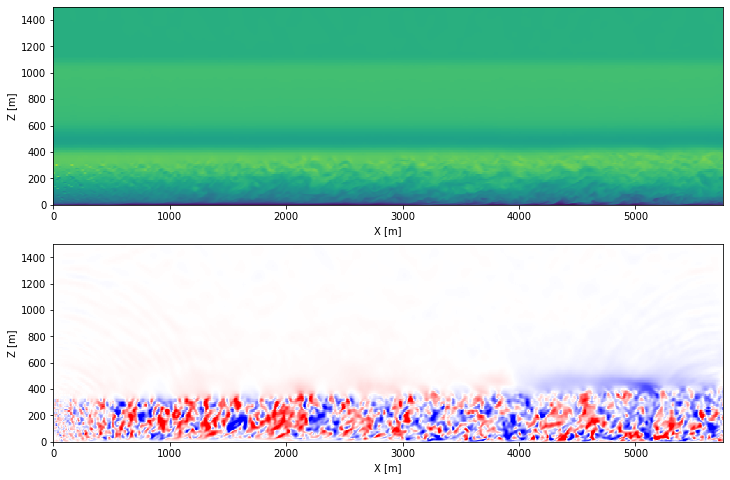

In [17]:
# Fig 2, W down X-Z plane in center of domain
f, ( ax1, ax2 )  = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 8))


pc = ax1.pcolormesh( ds3D.x, ds3D.z_us, \
              ds3D.U.isel( Time = -1, south_north = int(NY / 2), west_east_stag = slice(0, NX) ),
             #vmin = -1.5, vmax = 1.5, cmap = 'bwr')
                   )

ax1.set_ylim([0., 1500.])

ax1.set_xlabel('X [m]')
ax1.set_ylabel('Z [m]')


pc = ax2.pcolormesh( ds3D.x, ds3D.z, \
              ds3D.W.isel( Time = -1, south_north = int(NY / 2) ),
             vmin = -.5, vmax = .5, cmap = 'bwr')

ax2.set_ylim([0., 1500.])

ax2.set_xlabel('X [m]')
ax2.set_ylabel('Z [m]')


In [18]:
# Define limits to truncate northern and southern boundaries of the domain
if not load_data_2D:
    print("first postprocessing, truncate 2-D domain from north and south boundaries")

    j_y_lim_b = 20           #[index]
    j_y_lim_t = NY - 80      #[index]

    y_lim_b = ds2D.y.isel(y = j_y_lim_b).values
    y_lim_t = ds2D.y.isel(y = j_y_lim_t).values
else:
    print("postprocessing complete, updating NY to reflect truncated domain")
    NY = len(ds2D.y)

first postprocessing, truncate 2-D domain from north and south boundaries


### Plots illustrating rotation...skip if process data exists

/g/g12/lassman1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


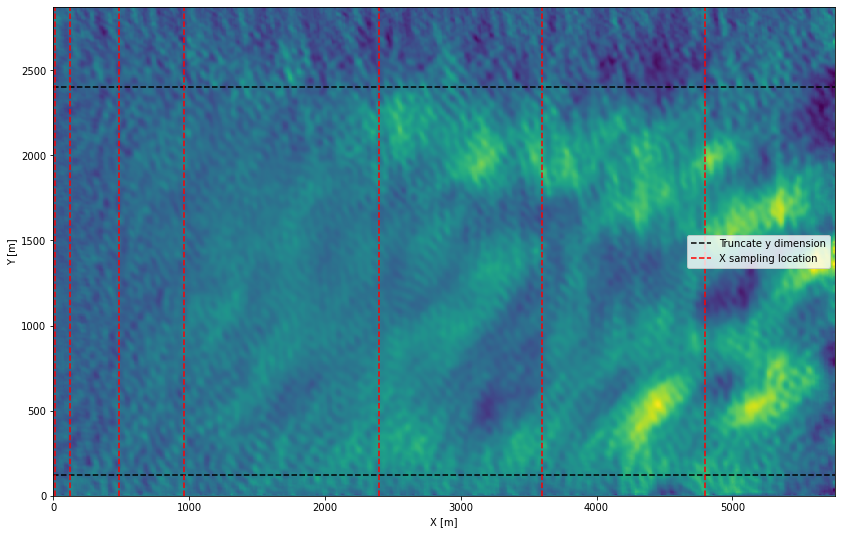

In [19]:
if not load_data_2D:
    # Fig 1, plan view pcolor of u_, rotated U.
    f, ax  = plt.subplots( figsize = (14, 9))

    ax.pcolormesh( ds2D.x, ds2D.y, \
                  ds2D.u_.isel( Time = 1, z = -1 ))#, vmin = 8, vmax = 10 )

    ax.plot( ds2D.x, np.ones(NX) * y_lim_b, 'k--', label = 'Truncate y dimension' )
    ax.plot( ds2D.x, np.ones(NX) * y_lim_t, 'k--' )

    ct = 0
    for x_i in x_locs:
        if ct ==0:
            ax.plot( np.ones(NY) * x_i, ds2D.y, 'r--' , label = 'X sampling location')
        else:
            ax.plot( np.ones(NY) * x_i, ds2D.y, 'r--' )
        ct += 1
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')

    ax.legend(loc = 'best')


/g/g12/lassman1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


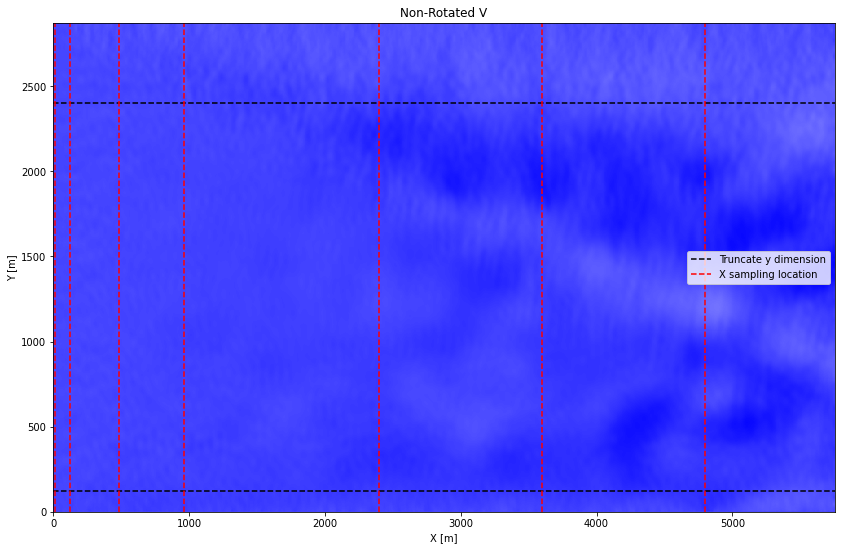

In [20]:
# Fig 1, plan view pcolor of v, non-rotated U.
## mean value of v is not equal to zero because the wind has a northerly component
if not load_data_2D:

    f, ax  = plt.subplots( figsize = (14, 9))

    ax.pcolormesh( ds2D.x, ds2D.y, \
                  ds2D.v.isel( Time = 1, z = -1 ), vmin = -4, vmax = -2, cmap = 'bwr' )

    ax.plot( ds2D.x, np.ones(NX) * y_lim_b, 'k--', label = 'Truncate y dimension' )
    ax.plot( ds2D.x, np.ones(NX) * y_lim_t, 'k--' )

    ct = 0
    for x_i in x_locs:
        if ct ==0:
            ax.plot( np.ones(NY) * x_i, ds2D.y, 'r--' , label = 'X sampling location')
        else:
            ax.plot( np.ones(NY) * x_i, ds2D.y, 'r--' )
        ct += 1
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')

    ax.legend(loc = 'best')
    ax.set_title('Non-Rotated V')

/g/g12/lassman1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':


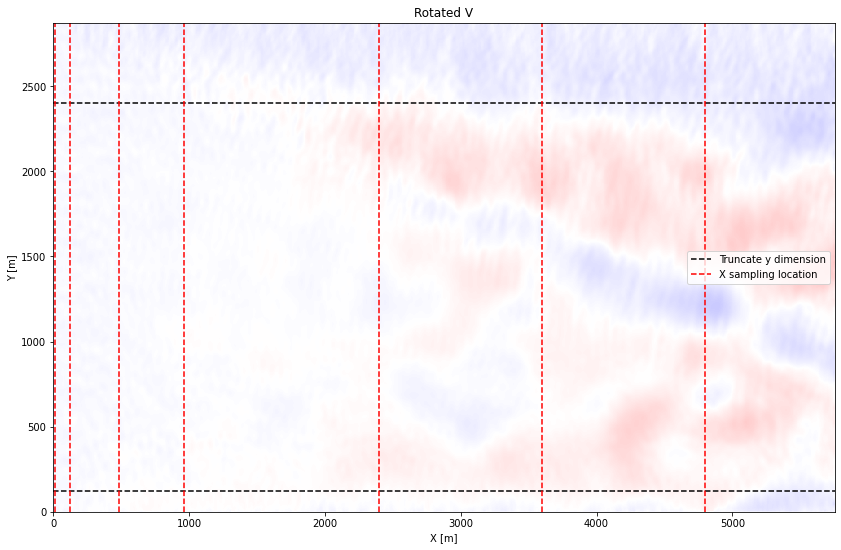

In [21]:
# Fig 1, plan view pcolor of v_, rotated U.
## mean value of v_ is zero because of rotation.

if not load_data_2D:

    f, ax  = plt.subplots( figsize = (14, 9))

    ax.pcolormesh( ds2D.x, ds2D.y, \
                  ds2D.v_.isel( Time = 1, z = -1 ), vmin = -1, vmax = 1, cmap = 'bwr' )

    ax.plot( ds2D.x, np.ones(NX) * y_lim_b, 'k--', label = 'Truncate y dimension' )
    ax.plot( ds2D.x, np.ones(NX) * y_lim_t, 'k--' )

    ct = 0
    for x_i in x_locs:
        if ct ==0:
            ax.plot( np.ones(NY) * x_i, ds2D.y, 'r--' , label = 'X sampling location')
        else:
            ax.plot( np.ones(NY) * x_i, ds2D.y, 'r--' )
        ct += 1
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')

    ax.legend(loc = 'best')
    ax.set_title('Rotated V')


### Truncate domain to remove edges (and to limit # of heights for speed of runtime)

In [22]:
if not load_data_2D:
    ds2D = ds2D.sel( y = slice(y_lim_b, y_lim_t))
    ds2D = ds2D.isel(z = [0, 2, 4, -1])
    NY = len(ds2D.y)
else:
    print('postprocessing already done')


/g/g12/lassman1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


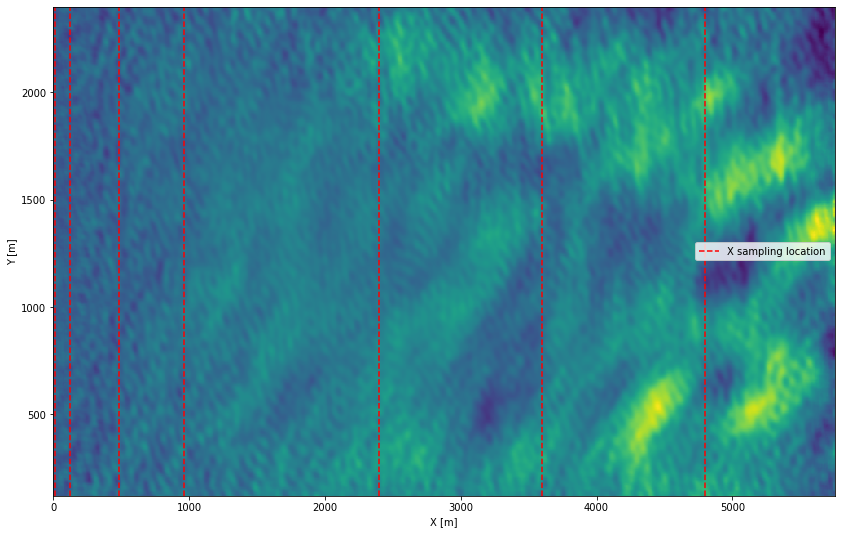

In [23]:
# Fig 1, plan view pcolor of u_, rotated U.
## boundaries are trimmed, so the inflow area should not be visible.
f, ax  = plt.subplots( figsize = (14, 9))

ax.pcolormesh( ds2D.x, ds2D.y, \
              ds2D.u_.isel( Time = 1, z = -1 ) )#, vmin = 7, vmax = 12 )

#ax.plot( ds2D.x, np.ones(NX) * y_lim_b, 'k--', label = 'Truncate y dimension' )
#ax.plot( ds2D.x, np.ones(NX) * y_lim_t, 'k--' )

ct = 0
for x_i in x_locs:
    if ct ==0:
        ax.plot( np.ones(NY) * x_i, ds2D.y, 'r--' , label = 'X sampling location')
    else:
        ax.plot( np.ones(NY) * x_i, ds2D.y, 'r--' )
    ct += 1
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')

ax.legend(loc = 'best')


# Analysis
Compute mean/perturbation quantities for u_, v_, w, T<br>
Compute resolved stresses and TKE<br>
Compute statistics for histogram (at designated x locations only)<br>
Compute spectra (at designated x locations only)<br>

In [24]:
if not load_data_2D:
    ds2D = calc_mean_pert( ds2D, variable_list = ['u_', 'v_', 'u', 'v', 'w', 'T'], mean_wind_dir = 'zonal', \
                                     mean_dim_nonperiodic = 'x' )
    
    ds2D = calc_tke( ds2D, mean_dims = 'y', \
                     U_vname = 'u__p', V_vname = 'v__p', W_vname = 'w_p' )

    ds2D = ds2D.rename({'TKE': 'TKE_resolved'})
    ds2D['TKE_total'] = ds2D.TKE_SGS.mean(dim = 'y') + ds2D.TKE_resolved
    ### NOTE ###
    # Need to compute stresses on non-rotated u/v.

    ds2D = calc_stresses( ds2D, mean_dims = 'y', do_vw = True, \
                               U_vname = 'u_p', V_vname = 'v_p', W_vname = 'w_p' )
    ds2D = ds2D.rename({'tau13': 'M13_resolved', 'tau23': 'M23_resolved'})
    

    ds2D['M13_total'] = ds2D.M13_SGS.mean(dim = 'y') + ds2D.M13_resolved
    
    print("saving...")
    ds2D.to_netcdf( pdata_dir + 'output_2D.nc')
else:
    print("Calculations already done, read from process data file")

u_
Zonal simulation, may need some temporal averaging for power
v_
Zonal simulation, may need some temporal averaging for power
u
Zonal simulation, may need some temporal averaging for power
v
Zonal simulation, may need some temporal averaging for power
w
Zonal simulation, may need some temporal averaging for power
T
Zonal simulation, may need some temporal averaging for power
calculating TKE...
calculating tau13...
calculating tau23...
saving...


### Plot TKE and stresses

0 of 4
1 of 4
2 of 4
3 of 4


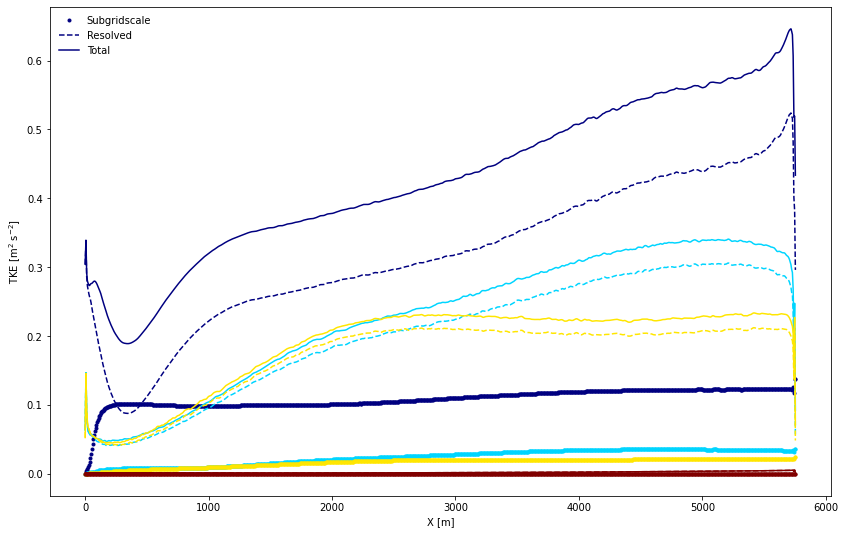

In [25]:
n = len(ds2D.z)
colors = plt.cm.jet(np.linspace(0,1,n))
f, ax = plt.subplots(figsize = (14, 9))

x = ds2D.x
TKE_res = ds2D.TKE_resolved.mean(dim = 'Time')
TKE_sgs = ds2D.TKE_SGS.mean(dim = ('y', 'Time') )
TKE_tot = ds2D.TKE_total.mean(dim = 'Time')
nplots = len(ds2D.z)
for k, z in enumerate(ds2D.z):
    print(f'{k} of {nplots}')
    if k == 0:
        ax.plot( x, TKE_sgs.isel(z = k), '.', c =  colors[k], label = 'Subgridscale' )
        ax.plot( x, TKE_res.isel(z = k), '--', c =  colors[k], label = 'Resolved' )
        ax.plot( x, TKE_tot.isel(z = k), c =  colors[k] , label = 'Total')
    else:
        ax.plot( x, TKE_sgs.isel(z = k), '.', c =  colors[k] )
        ax.plot( x, TKE_res.isel(z = k), '--', c =  colors[k] )
        ax.plot( x, TKE_tot.isel(z = k), c =  colors[k] )
    
ax.set_xlabel('X [m]')
ax.set_ylabel(r'TKE [m$^{2}$ s$^{-2}$]')
ax.legend(loc = 'best', frameon = False)

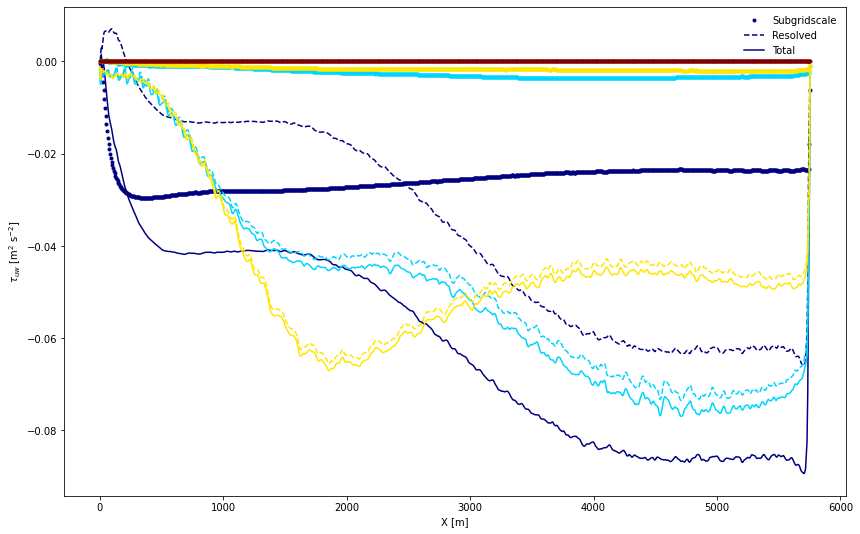

In [26]:
f, ax = plt.subplots(figsize = (14, 9))

x = ds2D.x
M13_res = ds2D.M13_resolved.mean(dim = 'Time')
M13_sgs = ds2D.M13_SGS.mean(dim = ('y', 'Time') )
M13_tot = ds2D.M13_total.mean(dim = 'Time')

for k, z in enumerate(ds2D.z):
    if k == 0:
        ax.plot( x, M13_sgs.isel(z = k), '.', c =  colors[k], label = 'Subgridscale' )
        ax.plot( x, M13_res.isel(z = k), '--', c =  colors[k], label = 'Resolved' )
        ax.plot( x, M13_tot.isel(z = k), c =  colors[k], label = 'Total' )
    else:
        ax.plot( x, M13_sgs.isel(z = k), '.', c =  colors[k] )
        ax.plot( x, M13_res.isel(z = k), '--', c =  colors[k] )
        ax.plot( x, M13_tot.isel(z = k), c =  colors[k] )

ax.set_xlabel('X [m]')
ax.set_ylabel(r'$\tau_{uw}$ [m$^{2}$ s$^{-2}$]')
ax.legend(loc = 'best', frameon = False)

## Calculate statistics/histogram
Some modifications to mmctools.helper_functions.model4D_pdfs were made, these need to be pushed to the team github

In [27]:
ds2D_xlocs = ds2D.sel( x = x_locs)
ds2D_xlocs = ds2D_xlocs.assign_coords( {'datetime' : ds2D_xlocs.Times})   


In [28]:
if os.path.exists(pdata_dir + 'stats_pdata.nc'):
    print("Stats process data exists")
    stats_ds = xr.open_dataset( pdata_dir + 'stats_pdata.nc' )
    load_data_stats = True
else:
    from mmctools.helper_functions import  model4D_pdfs

    bins_vector = np.linspace(-5.0,5.0,240)
    fld='w_p' #'theta'
    fldMean=None #'thetaMean'
    vertLevels = ds2D_xlocs.z
    iLocs = ds2D_xlocs.x
    print('Calculating PDF of {}'.format(fld))

    hist_cum, bin_edges, sk_vec, kurt_vec = model4D_pdfs(ds2D_xlocs,#.swap_dims({'Time':'datetime'}),\
                                                         'y',\
                                                         vertLevels,iLocs,\
                                                         fld = fld,fldMean = fldMean,bins_vector = bins_vector, \
                                                         time_dim = 'Time', x_dim = 'x', z_dim = 'z')
                                                         #)
        
    stats_ds = xr.Dataset()
    
    stats_dims_dict = {
            'dim_0':'vert_levels',
            'dim_1':'x',
            'dim_2': 'bins',
    }
    stats_ds['hist_cum']=xr.DataArray(hist_cum)
    stats_ds['bins']=xr.DataArray(bins_vector[:-1]+np.diff(bins_vector)/2.0,dims=['dim_2'])
    stats_ds['sk_vec']=xr.DataArray(sk_vec,dims=['dim_0','dim_1'])
    stats_ds['kurt_vec']=xr.DataArray(kurt_vec,dims=['dim_0','dim_1'])
    stats_ds = stats_ds.assign_coords(bins=stats_ds['bins'])
    #stats_ds.attrs['vert_level'] = vertLevels[0]
    #stats_ds['iLocs'] = xr.DataArray(iLocs,dims=['x'])

    #

    stats_ds = stats_ds.swap_dims(stats_dims_dict)
    stats_ds = stats_ds.assign_coords({'x':stats_ds.x})    
    
    stats_ds['x'] = x_locs
    stats_ds.to_netcdf(pdata_dir + 'stats_pdata.nc')


Calculating PDF of w_p
Accumulating statistics over 480 time-instances
0 0
0 1
0 2
0 3
0 4
0 5
0 6
1 0
1 1
1 2
1 3
1 4
1 5
1 6
2 0
2 1
2 2
2 3
2 4
2 5
2 6
3 0
3 1
3 2
3 3
3 4
3 5
3 6


### Histogram plots

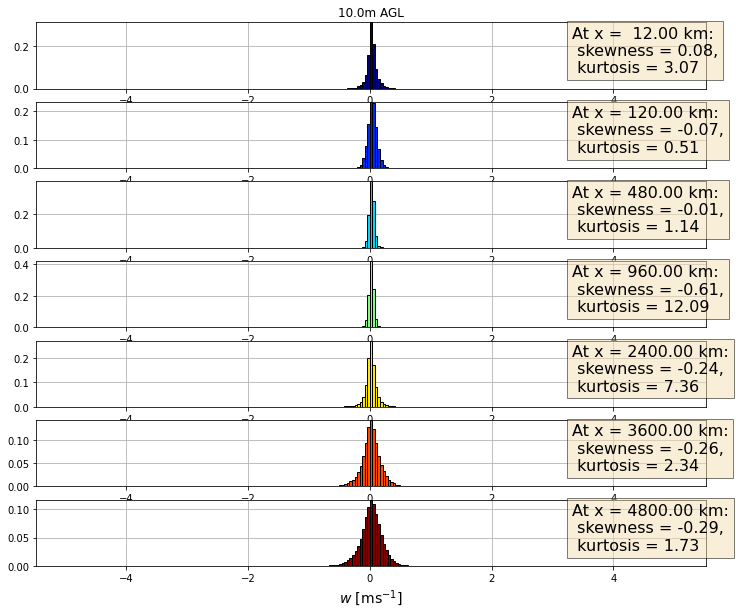

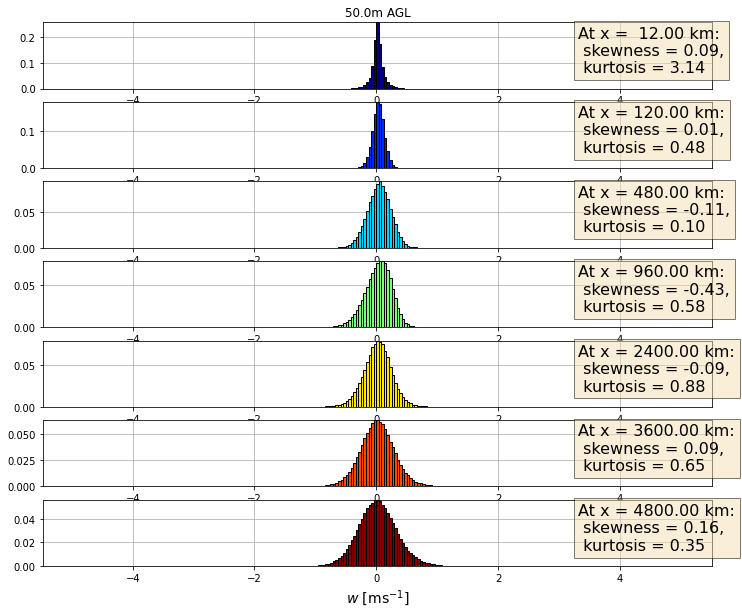

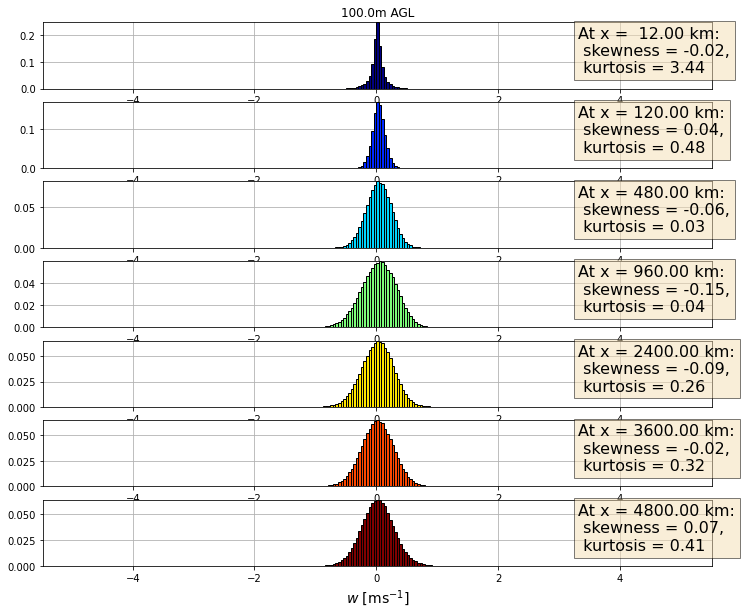

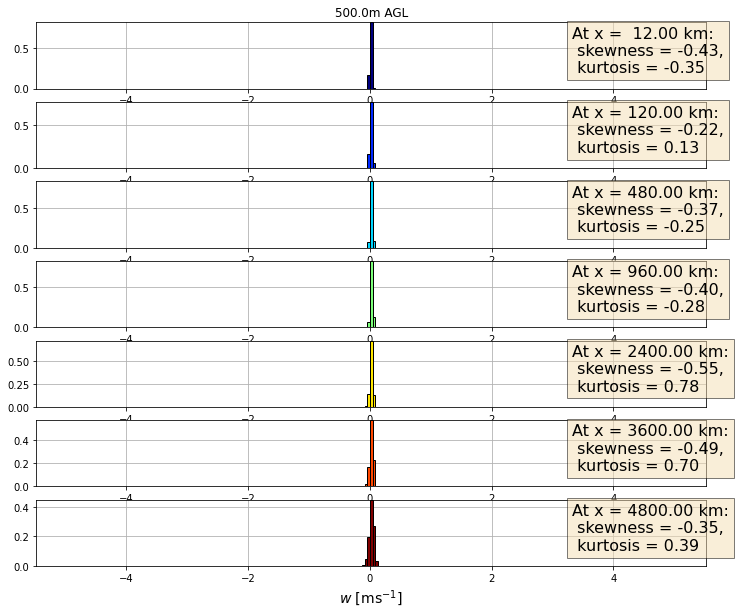

In [29]:
n = len(x_locs)
colors = plt.cm.jet(np.linspace(0,1,n))
nz = len(ds2D_xlocs.z)
fntSize = 14

bin_width = np.diff(stats_ds.bins)[0]
for cnt_lvl, z_curr in enumerate(ds2D_xlocs.z):


    denom = (ds2D_xlocs.dims['Time']*ds2D_xlocs.dims['y'])

    f, ax = plt.subplots( nrows = n, ncols = 1, figsize = (12,10) )


    #cnt_lvl=0
    cnt_i=0
    props = dict(boxstyle='square', facecolor='wheat', alpha=0.5)  #Properties for text boxes
    ax[0].set_title(f'{z_curr.values}m AGL')
    for iLoc in x_locs:
        
        x_str = x_locs[cnt_i]

        max_histval = np.amax(stats_ds.hist_cum[cnt_lvl,cnt_i,:]/denom)
        ax[cnt_i].grid(zorder=0)
        ### bins_vector[:-1] and bin_edges are equivalent
        im=ax[cnt_i].bar(stats_ds.bins, stats_ds.hist_cum[cnt_lvl,cnt_i,:]/denom, 
                         width=bin_width,color=colors[cnt_i], ec="k", align="edge",zorder=3)
        textstr ='At x = {:6.2f} km:\n skewness = {:4.2f},\n kurtosis = {:4.2f}'.format(x_str,
                                                                                    stats_ds.sk_vec[cnt_lvl,cnt_i].data,
                                                                                    stats_ds.kurt_vec[cnt_lvl,cnt_i].data)
        ax[cnt_i].text(0.80, 0.95, textstr, transform=ax[cnt_i].transAxes, fontsize=16,verticalalignment='top', bbox=props)
        ax[cnt_i].set_ylim(0.0,max_histval)
        ax[cnt_i].set_ylim(0.0,max_histval)
        if(cnt_i is len(x_locs)-1):
            ax[cnt_i].set_xlabel(r'$w`$ $[\mathrm{ms^{-1}}]$',fontsize=fntSize)
        cnt_i=cnt_i+1
    

## Spectra

In [ ]:
if os.path.exists(pdata_dir + 'spectra_pdata.nc'):
    print("Stats process data exists")
    psd_ds = xr.open_dataset( pdata_dir + 'spectra_pdata.nc' )
    load_data_spectra = True
else:
    from mmctools.helper_functions import calc_spectra

    ds2 = ds2D_xlocs.assign_coords( {'nx' : ds2D_xlocs.x, 'ny' : ds2D_xlocs.y, \
                                     'nz' : ds2D_xlocs.z, 'Time' : ds2D_xlocs.datetime})

    ds2 = ds2.swap_dims( {'x':'nx', 'y':'ny', 'z':'nz'})#, 'datetime':'Time'})
    #ds2 = ds2.isel(num_slices_stag = 0)#.drop('num_slices_stag')
    #ds2 = ds2D_xlocs.isel(num_slices_stag = 0)#.drop('num_slices_stag')

    psd_list_x = []
    NT = len(ds2.Time)
    #for tt in range(0,NT):
    for i, x in enumerate(ds2.nx.values):
        print(f"x {i} of {len(ds2.nx.values)}")
        psd_list_t = []
        for tt in range(0,NT):
            print(f"Time {tt} of {NT}")
            psd_hr1_temp = calc_spectra( ds2.isel(nx = i, Time = tt),\
                            var_oi=['u__p','w_p'],\
                            spectra_dim='ny',\
                            #average_dim='XTIME',\
                            average_dim=None,\
                            level_dim='nz',
            #                #level = [5, 10, 20, 40] \
                             )

            psd_list_t.append(psd_hr1_temp)#.mean(dim = 'Time'))
            #print( ds2.w_p.dims )
            #print(ds2.w_p.isel(nx = i, Time = tt).mean(dim = 'ny').values )
        psd_list_x.append( xr.concat( psd_list_t,  dim = 'Time').mean(dim = 'Time') )


    psd_ds = xr.concat( psd_list_x, "nx" )
    
    psd_ds = psd_ds.assign_coords({'x':ds2.x})
    psd_ds = psd_ds.assign_coords({'z':ds2.z})
    psd_ds.to_netcdf(pdata_dir + 'spectra_pdata.nc')



x 0 of 7
Time 0 of 480
Time 1 of 480
Time 2 of 480
Time 3 of 480
Time 4 of 480
Time 5 of 480
Time 6 of 480
Time 7 of 480
Time 8 of 480
Time 9 of 480
Time 10 of 480
Time 11 of 480
Time 12 of 480
Time 13 of 480
Time 14 of 480
Time 15 of 480
Time 16 of 480
Time 17 of 480
Time 18 of 480
Time 19 of 480
Time 20 of 480
Time 21 of 480
Time 22 of 480
Time 23 of 480
Time 24 of 480
Time 25 of 480
Time 26 of 480
Time 27 of 480
Time 28 of 480
Time 29 of 480
Time 30 of 480
Time 31 of 480
Time 32 of 480
Time 33 of 480
Time 34 of 480
Time 35 of 480
Time 36 of 480
Time 37 of 480
Time 38 of 480
Time 39 of 480
Time 40 of 480
Time 41 of 480
Time 42 of 480
Time 43 of 480
Time 44 of 480
Time 45 of 480
Time 46 of 480
Time 47 of 480
Time 48 of 480
Time 49 of 480
Time 50 of 480
Time 51 of 480
Time 52 of 480
Time 53 of 480
Time 54 of 480
Time 55 of 480
Time 56 of 480
Time 57 of 480
Time 58 of 480
Time 59 of 480
Time 60 of 480
Time 61 of 480
Time 62 of 480
Time 63 of 480
Time 64 of 480
Time 65 of 480
Time 66 of 

Time 41 of 480
Time 42 of 480
Time 43 of 480
Time 44 of 480
Time 45 of 480
Time 46 of 480
Time 47 of 480
Time 48 of 480
Time 49 of 480
Time 50 of 480
Time 51 of 480
Time 52 of 480
Time 53 of 480
Time 54 of 480
Time 55 of 480
Time 56 of 480
Time 57 of 480
Time 58 of 480
Time 59 of 480
Time 60 of 480
Time 61 of 480
Time 62 of 480
Time 63 of 480
Time 64 of 480
Time 65 of 480
Time 66 of 480
Time 67 of 480
Time 68 of 480
Time 69 of 480
Time 70 of 480
Time 71 of 480
Time 72 of 480
Time 73 of 480
Time 74 of 480
Time 75 of 480
Time 76 of 480
Time 77 of 480
Time 78 of 480
Time 79 of 480
Time 80 of 480
Time 81 of 480
Time 82 of 480
Time 83 of 480
Time 84 of 480
Time 85 of 480
Time 86 of 480
Time 87 of 480
Time 88 of 480
Time 89 of 480
Time 90 of 480
Time 91 of 480
Time 92 of 480
Time 93 of 480
Time 94 of 480
Time 95 of 480
Time 96 of 480
Time 97 of 480
Time 98 of 480
Time 99 of 480
Time 100 of 480
Time 101 of 480
Time 102 of 480
Time 103 of 480
Time 104 of 480
Time 105 of 480
Time 106 of 480
Tim

Time 82 of 480
Time 83 of 480
Time 84 of 480
Time 85 of 480
Time 86 of 480
Time 87 of 480
Time 88 of 480
Time 89 of 480
Time 90 of 480
Time 91 of 480
Time 92 of 480
Time 93 of 480
Time 94 of 480
Time 95 of 480
Time 96 of 480
Time 97 of 480
Time 98 of 480
Time 99 of 480
Time 100 of 480
Time 101 of 480
Time 102 of 480
Time 103 of 480
Time 104 of 480
Time 105 of 480
Time 106 of 480
Time 107 of 480
Time 108 of 480
Time 109 of 480
Time 110 of 480
Time 111 of 480
Time 112 of 480
Time 113 of 480
Time 114 of 480
Time 115 of 480
Time 116 of 480
Time 117 of 480
Time 118 of 480
Time 119 of 480
Time 120 of 480
Time 121 of 480
Time 122 of 480
Time 123 of 480
Time 124 of 480
Time 125 of 480
Time 126 of 480
Time 127 of 480
Time 128 of 480
Time 129 of 480
Time 130 of 480
Time 131 of 480
Time 132 of 480
Time 133 of 480
Time 134 of 480
Time 135 of 480
Time 136 of 480
Time 137 of 480
Time 138 of 480
Time 139 of 480
Time 140 of 480
Time 141 of 480
Time 142 of 480
Time 143 of 480
Time 144 of 480
Time 145 o

Time 122 of 480
Time 123 of 480
Time 124 of 480
Time 125 of 480
Time 126 of 480
Time 127 of 480
Time 128 of 480
Time 129 of 480
Time 130 of 480
Time 131 of 480
Time 132 of 480
Time 133 of 480
Time 134 of 480
Time 135 of 480
Time 136 of 480
Time 137 of 480
Time 138 of 480
Time 139 of 480
Time 140 of 480
Time 141 of 480
Time 142 of 480
Time 143 of 480
Time 144 of 480
Time 145 of 480
Time 146 of 480
Time 147 of 480
Time 148 of 480
Time 149 of 480
Time 150 of 480
Time 151 of 480
Time 152 of 480
Time 153 of 480
Time 154 of 480
Time 155 of 480
Time 156 of 480
Time 157 of 480
Time 158 of 480
Time 159 of 480
Time 160 of 480
Time 161 of 480
Time 162 of 480
Time 163 of 480
Time 164 of 480
Time 165 of 480
Time 166 of 480
Time 167 of 480
Time 168 of 480
Time 169 of 480
Time 170 of 480
Time 171 of 480
Time 172 of 480
Time 173 of 480
Time 174 of 480
Time 175 of 480
Time 176 of 480
Time 177 of 480
Time 178 of 480
Time 179 of 480
Time 180 of 480
Time 181 of 480
Time 182 of 480
Time 183 of 480
Time 184

In [ ]:
nx = len(psd_ds.x)
nz = len(psd_ds.z)

colors = plt.cm.jet(np.linspace(0,1,nx))

f, axarr = plt.subplots( nrows = nz, ncols = 2, figsize = (14, 20) )

for k, z in enumerate( psd_ds.z):
    for i, x in enumerate(psd_ds.x):
        axarr[k,0].plot( psd_ds.frequency, psd_ds.u__p.isel(nz = k, nx = i), c = colors[i],\
            label = f"x = {psd_ds.x.isel(nx=i).values:.1f} m" )
        
        axarr[k,1].plot( psd_ds.frequency, psd_ds.w_p.isel(nz = k, nx = i), c = colors[i],\
            label = f"x = {psd_ds.x.isel(nx=i).values:.1f} m" )
        axarr[k,0].set_xscale('log')
        axarr[k,0].set_yscale('log')
        axarr[k,1].set_xscale('log')
        axarr[k,1].set_yscale('log')
        
        axarr[k,0].set_title( f'U, z = {psd_ds.z.isel(nz  = k).values}m' )
        axarr[k,1].set_title( f'W, z = {psd_ds.z.isel(nz  = k).values}m' )
        

axarr[0,0].legend(loc = 'best', frameon = False)
print(axarr.shape)

In [ ]:
psd_ds['u__p_norm_power'] = psd_ds.u__p * psd_ds.frequency
psd_ds['w_p_norm_power'] = psd_ds.w_p * psd_ds.frequency

In [ ]:
nx = len(psd_ds.x)
nz = len(psd_ds.z)

colors = plt.cm.jet(np.linspace(0,1,nx))

f, axarr = plt.subplots( nrows = nz, ncols = 2, figsize = (14, 20) )

for k, z in enumerate( psd_ds.z):
    for i, x in enumerate(psd_ds.x):
        axarr[k,0].plot( psd_ds.frequency, psd_ds.u__p_norm_power.isel(nz = k, nx = i), c = colors[i],\
            label = f"x = {psd_ds.x.isel(nx=i).values:.1f} m" )
        
        axarr[k,1].plot( psd_ds.frequency, psd_ds.w_p_norm_power.isel(nz = k, nx = i), c = colors[i],\
            label = f"x = {psd_ds.x.isel(nx=i).values:.1f} m" )
        axarr[k,0].set_xscale('log')
        axarr[k,0].set_yscale('log')
        axarr[k,1].set_xscale('log')
        axarr[k,1].set_yscale('log')
        
        axarr[k,0].set_title( f'U, z = {psd_ds.z.isel(nz  = k).values}m' )
        axarr[k,1].set_title( f'W, z = {psd_ds.z.isel(nz  = k).values}m' )
        
axarr[0,0].legend(loc = 'best', frameon = False)


print(axarr.shape)